# Data block API foundations

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_07a import *

In [ ]:
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160'

## Image ItemList

Previously we were reading in to RAM the whole MNIST dataset at once, loading it as a pickle file. We can't do that for datasets larger than our RAM capacity, so instead we leave the images on disk and just grab the ones we need for each mini-batch as we use them.

Let's use the [imagenette dataset](https://github.com/fastai/imagenette/blob/master/README.md) and build the data blocks we need along the way.

### Get images

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/home/jhoward/.fastai/data/imagenette-160')

To be able to look at what's inside a directory from a notebook, we add the `.ls` method to `Path` with a monkey-patch.

In [ ]:
#export
import PIL,os,mimetypes
Path.ls = lambda x: list(x.iterdir())

In [ ]:
path.ls()

[PosixPath('/home/jhoward/.fastai/data/imagenette-160/val'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/models'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/train'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/tmp')]

In [ ]:
(path/'val').ls()

[PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03417042'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03028079'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n02102040'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03445777'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n01440764'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03000684'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03888257'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n02979186'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03394916')]

Let's have a look inside a class folder (the first class is tench):

In [ ]:
path_tench = path/'val'/'n01440764'

In [ ]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00006697.JPEG')

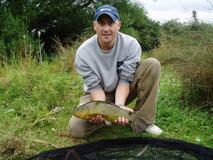

In [ ]:
img = PIL.Image.open(img_fn)
img

In [ ]:
import numpy
imga = numpy.array(img)

In [ ]:
imga.shape

(160, 213, 3)

In [ ]:
imga[:10,:10,0]

array([[ 45,  38,  66,  87, ...,  50,  13,   0,   8],
       [ 15, 100, 115,  63, ...,   0,  32,  21,  15],
       [ 37, 106, 156,  79, ...,  20,  28,  49,  27],
       [ 30,  11,  59,  13, ...,  78,  58,  51,  27],
       ...,
       [ 30,  28,  36,  35, ...,   7,  16,   5,  20],
       [ 48,  28,  26,  14, ...,  21,   0,  15,  33],
       [ 25,  30,  17,  30, ...,  41,  17,  12,  79],
       [ 25,  29,  17,  35, ...,  37,   8,  27,  65]], dtype=uint8)

Just in case there are other files in the directory (models, texts...) we want to keep only the images. Let's not write it out by hand, but instead use what's already on our computer (the MIME types database).

In [ ]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [ ]:
' '.join(image_extensions)

'.jpeg .pgm .rgb .tif .tiff .gif .ras .pbm .bmp .png .xbm .ico .xwd .ppm .ief .pnm .xpm .svg .jpg .jpe'

In [ ]:
#export
def setify(o): return o if isinstance(o,set) else set(listify(o))

In [ ]:
test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa',1]), {'aa',1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

Now let's walk through the directories and grab all the images. The first private function grabs all the images inside a given directory and the second one walks (potentially recursively) through all the folder in `path`.

In [ ]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [ ]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/home/jhoward/.fastai/data/imagenette-160/ILSVRC2012_val_00006697.JPEG'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/ILSVRC2012_val_00025129.JPEG'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/ILSVRC2012_val_00037861.JPEG')]

In [ ]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [ ]:
get_files(path_tench, image_extensions)[:3]

[PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00006697.JPEG'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00025129.JPEG'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00037861.JPEG')]

We need the recurse argument when we start from `path` since the pictures are two level below in directories.

In [ ]:
get_files(path, image_extensions, recurse=True)[:3]

[PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00035211.JPEG'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00022538.JPEG'),
 PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00005996.JPEG')]

In [ ]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

Imagenet is 100 times bigger than imagenette, so we need this to be fast.

In [ ]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

67.6 ms ± 644 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Prepare for modeling

What we need to do:

- Get files
- Split validation set
  - random%, folder name, csv, ...
- Label: 
  - folder name, file name/re, csv, ...
- Transform per image (optional)
- Transform to tensor
- DataLoader
- Transform per batch (optional)
- DataBunch
- Add test set (optional)

### Get files

We use the `ListContainer` class from notebook 08 to store our objects in an `ItemList`. The `get` method will need to be subclassed to explain how to access an element (open an image for instance), then the private `_get` method can allow us to apply any additional transform to it.

`new` will be used in conjunction with `__getitem__` (that works for one index or a list of indices) to create training and validation set from a single stream when we split the data.

In [ ]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)

class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

Transforms aren't only used for data augmentation. To allow total flexibility, `ImageList` returns the raw PIL image. The first thing is to convert it to 'RGB' (or something else).

Transforms only need to be functions that take an element of the `ItemList` and transform it. If they need state, they can be defined as a class. Also, having them as a class allows to define an `_order` attribute (default 0) that is used to sort the transforms.

In [ ]:
#export
class Transform(): _order=0

class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

In [ ]:
il = ImageList.from_files(path, tfms=make_rgb)

In [ ]:
il

ImageList (13394 items)
[PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00035211.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00022538.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00005996.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00046178.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00045353.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00018516.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00009821.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00048059.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00004452.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00

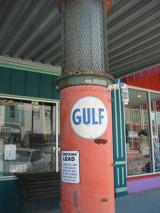

In [ ]:
img = il[0]; img

We can also index with a range or a list of intergers:

In [ ]:
il[:1]

[<PIL.Image.Image image mode=RGB size=160x213 at 0x7F2D38EB8438>]

### Split validation set

Here, we need to split the files between those in the folder train and those in the folder val.

In [ ]:
fn = il.items[0]; fn

PosixPath('/home/jhoward/.fastai/data/imagenette-160/val/n03425413/ILSVRC2012_val_00035211.JPEG')

Since our filenames are `path` object, we can find the directory of the file with `.parent`. We need to go back two folders before since the last folders are the class names.

In [ ]:
fn.parent.parent.name

'val'

In [ ]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

def split_by_func(items, f):
    mask = [f(o) for o in items]
    # `None` values will be filtered out
    f = [o for o,m in zip(items,mask) if m==False]
    t = [o for o,m in zip(items,mask) if m==True ]
    return f,t

In [ ]:
splitter = partial(grandparent_splitter, valid_name='val')

In [ ]:
%time train,valid = split_by_func(il, splitter)

CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 74.2 ms


In [ ]:
len(train),len(valid)

(12894, 500)

Now that we can split our data, let's create the class that will contain it. It just needs two `ItemList` to be initialized, and we create a shortcut to all the unknown attributes by trying to grab them in the `train` `ItemList`. 

In [ ]:
#export
class SplitData():
    def __init__(self, train, valid): self.train,self.valid = train,valid
        
    def __getattr__(self,k): return getattr(self.train,k)
    #This is needed if we want to pickle SplitData and be able to load it back without recursion errors
    def __setstate__(self,data:Any): self.__dict__.update(data) 
    
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
        return cls(*lists)

    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [ ]:
sd = SplitData.split_by_func(il, splitter); sd

SplitData
Train: ImageList (12894 items)
[PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_12098.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_12962.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_19116.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_21315.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_15109.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_19574.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_13479.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_14027.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_18953.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_12686.JPEG')...]
Path: /home/jhoward/.fast

### Labeling

Labeling has to be done *after* splitting, because it uses *training* set information to apply to the *validation* set, using a *Processor*.

A *Processor* is a transformation that is applied to all the inputs once at initialization, with some *state* computed on the training set that is then applied without modification on the validation set (and maybe the test set or at inference time on a single item). For instance, it could be **processing texts** to **tokenize**, then **numericalize** them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in **tabular data**, where we **fill missing values** with (for instance) the median computed on the training set. That statistic is stored in the inner state of the *Processor* and applied on the validation set.

In our case, we want to **convert label strings to numbers** in a consistent and reproducible way. So we create a list of possible labels in the training set, and then convert our labels to numbers based on this *vocab*.

In [ ]:
#export
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res

First, let's define the processor. We also define a `ProcessedItemList` with an `obj` method that can get the unprocessed items: for instance a processed label will be an index between 0 and the number of classes - 1, the corresponding `obj` will be the name of the class. The first one is needed by the model for the training, but the second one is better for displaying the objects.

In [ ]:
#export
class Processor(): 
    def process(self, items): return items

class CategoryProcessor(Processor):
    def __init__(self): self.vocab=None
    
    def __call__(self, items):
        #The vocab is defined on the first use.
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    def proc1(self, item):  return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    def deproc1(self, idx): return self.vocab[idx]

Here we label according to the folders of the images, so simply `fn.parent.name`. We label the training set first with a newly created `CategoryProcessor` so that it computes its inner `vocab` on that set. Then we label the validation set using the same processor, which means it uses the same `vocab`. The end result is another `SplitData` object.

In [ ]:
#export
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)

#This is a slightly different from what was seen during the lesson,
#   we'll discuss the changes in lesson 11
class LabeledData():
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x,self.y = self.process(x, proc_x),self.process(y, proc_y)
        self.proc_x,self.proc_y = proc_x,proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx,torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)

def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

In [ ]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [ ]:
assert ll.train.proc_y is ll.valid.proc_y

In [ ]:
ll.train.y

ItemList (12894 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: /home/jhoward/.fastai/data/imagenette-160

In [ ]:
ll.train.y.items[0], ll.train.y_obj(0), ll.train.y_obj(slice(2))

(0, 'n03425413', ['n03425413', 'n03425413'])

In [ ]:
ll

SplitData
Train: LabeledData
x: ImageList (12894 items)
[PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_12098.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_12962.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_19116.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_21315.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_15109.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_19574.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_13479.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_14027.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_18953.JPEG'), PosixPath('/home/jhoward/.fastai/data/imagenette-160/train/n03425413/n03425413_12686.JPEG')...]
Path: /hom

### Transform to tensor

In [ ]:
ll.train[0]

(<PIL.Image.Image image mode=RGB size=160x189 at 0x7F9FC4226208>, 0)

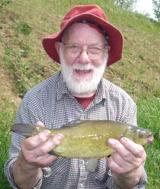

In [ ]:
ll.train[0][0]

To be able to put all our images in a batch, we need them to have all the same size. We can do this easily in PIL.

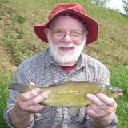

In [ ]:
ll.train[0][0].resize((128,128))

The first transform resizes to a given size, then we convert the image to a by tensor before converting it to float and dividing by 255. We will investigate data augmentation transforms at length in notebook 10.

In [ ]:
#export
class ResizeFixed(Transform):
    _order=10
    def __init__(self,size):
        if isinstance(size,int): size=(size,size)
        self.size = size
        
    def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)

def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)
to_byte_tensor._order=20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order=30

In [ ]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

Here is a little convenience function to show an image from the corresponding tensor.

In [ ]:
#export
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

In [ ]:
x,y = ll.train[0]
x.shape

torch.Size([3, 128, 128])

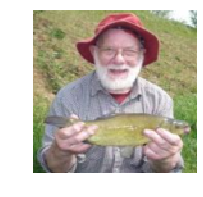

In [ ]:
show_image(x)

## Modeling

### DataBunch

Now we are ready to put our datasets together in a `DataBunch`.

In [ ]:
bs=64

In [ ]:
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=4)

In [ ]:
x,y = next(iter(train_dl))

In [ ]:
x.shape

torch.Size([64, 3, 128, 128])

We can still see the images in a batch and get the corresponding classes.

'n03000684'

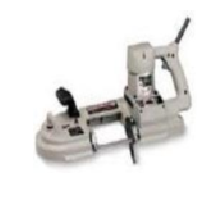

In [ ]:
show_image(x[0])
ll.train.y.processors[0].vocab[y[0]]

In [ ]:
y

tensor([2, 0, 2, 7, 7, 6, 6, 2, 2, 3, 4, 9, 0, 0, 6, 6, 5, 1, 5, 6, 6, 1, 1, 3,
        2, 8, 2, 2, 2, 2, 8, 8, 4, 7, 8, 7, 0, 4, 7, 8, 0, 8, 1, 2, 9, 4, 2, 9,
        1, 9, 4, 4, 9, 4, 9, 8, 3, 6, 3, 8, 2, 4, 2, 8])

We change a little bit our `DataBunch` to add a few attributes: `c_in` (for channel in) and `c_out` (for channel out) instead of just `c`. This will help when we need to build our model.

In [ ]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl,self.valid_dl,self.c_in,self.c_out = train_dl,valid_dl,c_in,c_out

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

Then we define a function that goes directly from the `SplitData` to a `DataBunch`.

In [ ]:
#export
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

This gives us the full summary on how to grab our data and put it in a `DataBunch`:

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

### Model

In [ ]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback]

We will normalize with the statistics from a batch.

In [ ]:
m,s = x.mean((0,2,3)).cuda(),x.std((0,2,3)).cuda()
m,s

(tensor([0.4713, 0.4686, 0.4581], device='cuda:0'),
 tensor([0.2741, 0.2748, 0.3058], device='cuda:0'))

In [ ]:
#export
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [ ]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

In [ ]:
nfs = [64,64,128,256]

We build our model using [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187), in particular: we don't use a big conv 7x7 at first but three 3x3 convs, and don't go directly from 3 channels to 64 but progressively add those.

In [ ]:
#export
import math
def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1*3*3)
    layers =  [f(l1  , l2  , stride=1),
               f(l2  , l2*2, stride=2),
               f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), 
               nn.Linear(nfs[-1], data.c_out)]
    return layers

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
sched = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.1,0.3,0.05))

In [ ]:
learn,run = get_learn_run(nfs, data, 0.2, conv_layer, cbs=cbfs+[
    partial(ParamScheduler, 'lr', sched)
])

Let's have a look at our model using Hooks. We print the layers and the shapes of their outputs.

In [ ]:
#export
def model_summary(run, learn, find_all=False):
    xb,yb = get_batch(data.valid_dl, run)
    device = next(learn.model.parameters()).device#Model may not be on the GPU yet
    xb,yb = xb.to(device),yb.to(device)
    mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
    f = lambda hook,mod,inp,out: print(f"{mod}\n{out.shape}\n")
    with Hooks(mods, f) as hooks: learn.model(xb)

In [ ]:
model_summary(run, learn)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 16, 128, 128])

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 32, 64, 64])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 32, 32])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 16, 16])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(

And we can train the model:

In [ ]:
%time run.fit(5, learn)

train: [1.7771825800760044, tensor(0.3843, device='cuda:0')]
valid: [1.769573486328125, tensor(0.4260, device='cuda:0')]
train: [1.3437446983577632, tensor(0.5485, device='cuda:0')]
valid: [1.352245849609375, tensor(0.5520, device='cuda:0')]
train: [1.0356472578088647, tensor(0.6611, device='cuda:0')]
valid: [1.1400950927734375, tensor(0.6160, device='cuda:0')]
train: [0.7812843091990461, tensor(0.7474, device='cuda:0')]
valid: [0.9102987670898437, tensor(0.7000, device='cuda:0')]
train: [0.573325991316213, tensor(0.8200, device='cuda:0')]
valid: [0.84834716796875, tensor(0.7260, device='cuda:0')]
CPU times: user 30.1 s, sys: 13.2 s, total: 43.3 s
Wall time: 45.7 s


The [leaderboard](https://github.com/fastai/imagenette/blob/master/README.md) as this notebook is written has ~85% accuracy for 5 epochs at 128px size, so we're definitely on the right track!

## Export

In [ ]:
!python notebook2script.py 08_data_block.ipynb

Converted 08_data_block.ipynb to exp/nb_08.py
